# Hilbert-Huang Transform (HHT) Analysis Tutorial

This tutorial explains the procedure for **Hilbert-Huang Transform (HHT)** analysis using **gwexpy**.
HHT is well-suited for analyzing nonlinear and non-stationary signals, and is a powerful method for extracting local frequency variations (instantaneous frequency) that cannot be captured by traditional Fourier or wavelet transforms.
The sample code in this tutorial uses `TimeSeries.hht()`.

HHT consists of two main steps:
1.  **Empirical Mode Decomposition (EMD)**: Decomposes the signal into Intrinsic Mode Functions (IMFs).
2.  **Hilbert Spectral Analysis**: Applies the Hilbert transform to each IMF to calculate instantaneous amplitude and instantaneous frequency.

**Note**: To use this feature, the `PyEMD` (EMD-signal) package must be installed.
```bash
pip install EMD-signal
```

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/advanced_hht.ipynb)


In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.timeseries import TimeSeries

# Check PyEMD installation
try:
    import PyEMD

    print("PyEMD is installed and ready.")
except ImportError:
    raise ImportError(
        "This tutorial requires 'PyEMD' (EMD-signal). Please run: pip install EMD-signal"
    )

PyEMD is installed and ready.


## 1. Theoretical Background and Advantages of HHT

### What is HHT (Hilbert-Huang Transform)?
HHT is a powerful method for analyzing nonlinear and non-stationary signal data.
It consists of two main processes:

1.  **EMD (Empirical Mode Decomposition)**: Decomposes the original signal into a sum of Intrinsic Mode Functions (IMFs) with different frequency scales.
2.  **HSA (Hilbert Spectral Analysis)**: Applies the Hilbert transform to each IMF to calculate **Instantaneous Frequency** and instantaneous amplitude.

### Differences from Traditional STFT
Short-Time Fourier Transform (STFT) and wavelet transforms have a trade-off between time resolution and frequency resolution (limited by the uncertainty principle).
In contrast, HHT adaptively generates basis functions based on local time scales, so it is not subject to this limitation and can achieve **high time and frequency resolution** simultaneously.

### EEMD (Ensemble EMD)
In standard EMD, "mode mixing" can occur where different frequency components are mixed within a single IMF due to intermittent signals or noise.
To solve this, **EEMD (Ensemble EMD)** has been proposed.
-   Generate multiple ensemble members by adding white noise to the original signal.
-   Perform EMD on each signal.
-   Take the ensemble average of the resulting IMFs to cancel out the noise and stably extract physically meaningful modes.


## 2. Simulation: Reproducing SASI Modes

In gravitational wave analysis of core-collapse supernovae (CCSN), the instability called **SASI (Standing Accretion Shock Instability)** is an important observation target.
Here, we create a **Sine-Gaussian** signal simulating gravitational waves from SASI and analyze it (Reference: Takeda et al. 2021).

The Sine-Gaussian signal is expressed by the following equation:
$$ h(t) = A \exp\left( - \left( \frac{2\pi (t - t_0)}{t_{\text{width}}} \right)^2 \right) \sin(2\pi f_0 t) $$


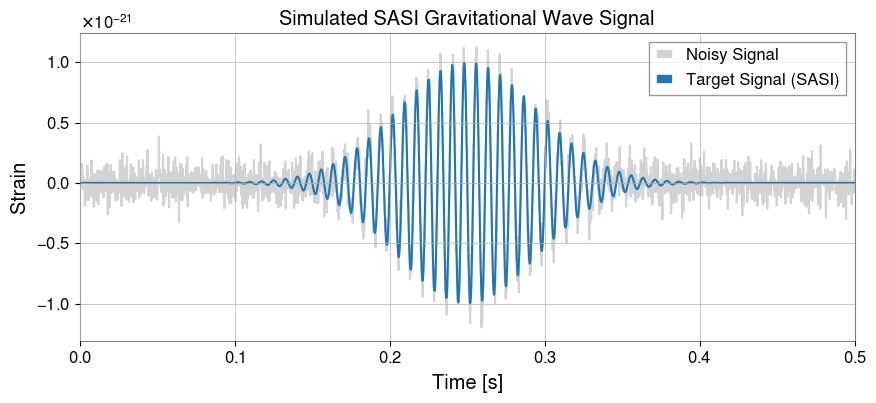

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries


def sine_gaussian(t, t0, t_width, f0, amp=1.0):
    exponent = -(((2 * np.pi * (t - t0)) / t_width) ** 2)
    return amp * np.exp(exponent) * np.sin(2 * np.pi * f0 * t)


# Parameter settings (mimicking SASI mode)
duration = 0.5  # seconds
fs = 4096  # sampling rate
t = np.linspace(0, duration, int(duration * fs))

# Generate signal
t0 = 0.25  # peak time
t_width = 0.4  # width
f0 = 130.0  # frequency (Hz)
clean_signal = sine_gaussian(t, t0, t_width, f0, amp=1e-21)

# Add noise
np.random.seed(42)
noise_amp = 0.1e-21
noise = np.random.normal(0, noise_amp, len(t))
data = clean_signal + noise

# Create TimeSeries object
ts_data = TimeSeries(
    data, t0=0, sample_rate=fs, name="Simulated SASI Signal", unit="strain"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t, ts_data.value, label="Noisy Signal", color="lightgray")
ax.plot(t, clean_signal, label="Target Signal (SASI)", color="tab:blue")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Strain")
ax.set_xlim(0, duration)
ax.legend()
plt.title("Simulated SASI Gravitational Wave Signal")
plt.show()

## 3. Comparative Analysis: STFT vs HHT

We apply STFT (spectrogram) and HHT (Hilbert spectrum) to the same signal and compare their resolution differences.


**Note**: In the following results, STFT may appear more robust to noise and the signal may look cleaner.
This is because standard EMD is susceptible to noise and causes "mode mixing."
This problem is dramatically improved by using **EEMD**, which we will introduce in the next section, but let's first check the basic behavior of HHT.


Extracted 8 IMFs from normalized data.


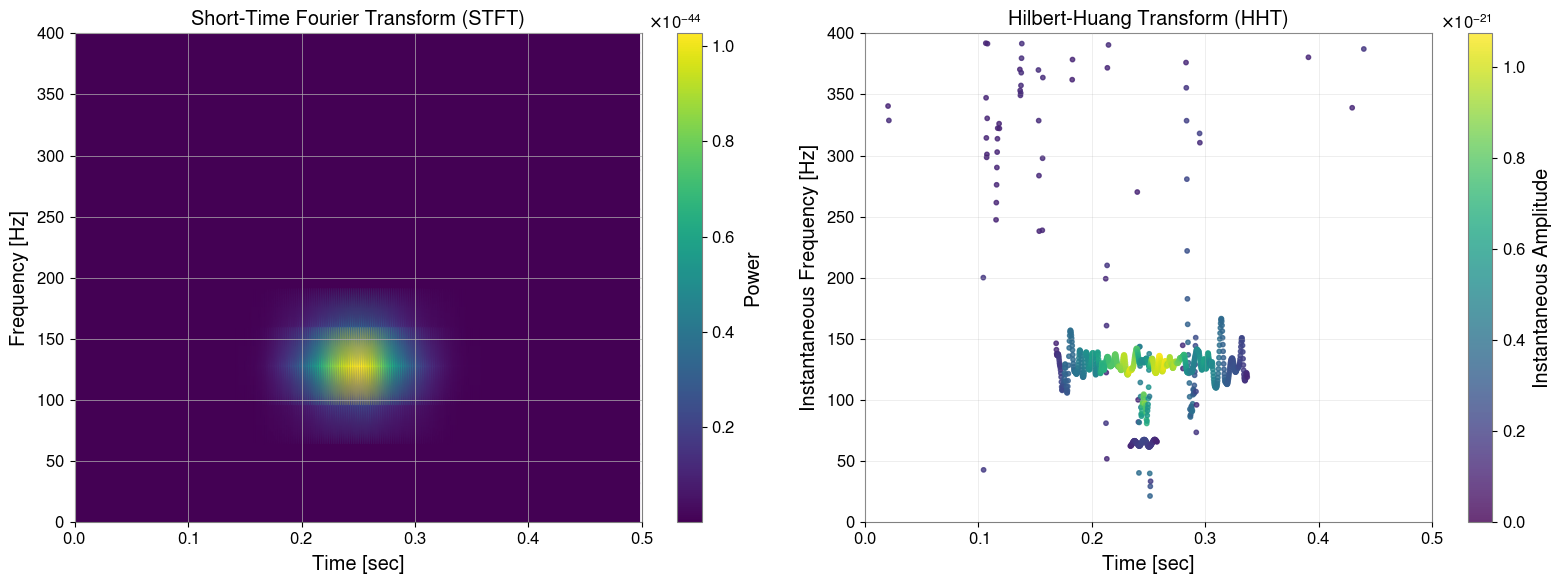

In [3]:
# --- 1. STFT (Spectrogram) using gwexpy API ---
# Convert sample counts to time-based parameters for gwexpy API:
# nperseg=128 samples → fftlength = 128/fs seconds
# noverlap=120 samples → overlap = 120/fs seconds
# spectrogram2 computes an STFT-like spectrogram (no stride needed)
spec = ts_data.spectrogram2(fftlength=128/fs, overlap=120/fs)
f_stft = spec.frequencies.value
t_stft = spec.times.value
Sxx = spec.value

# --- 2. HHT (EMD + Hilbert) ---
# Important: EMD has numerical tolerance, so it may not decompose well for very small amplitudes (e.g., 1e-21 for GW).
# Therefore, we normalize the data first, then scale back the results.
data_std = np.std(ts_data.value)
ts_norm = TimeSeries(
    ts_data.value / data_std,
    t0=ts_data.t0,
    sample_rate=ts_data.sample_rate,
    name="Normalized SASI Signal",
    unit=ts_data.unit,
)

hht_result = ts_norm.hht(
    emd_method="emd",
    emd_kwargs={
        "sift_max_iter": 200,
        "stopping_criterion": 0.2,
    },
    hilbert_kwargs={
        "pad": 200,
        "if_smooth": 11,
    },
    output="dict",
)

imfs = hht_result["imfs"]
if_dict = hht_result["if"]
ia_dict = hht_result["ia"]
n_imfs = len(imfs)

print(f"Extracted {n_imfs} IMFs from normalized data.")

# --- Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# STFT
mesh = ax1.pcolormesh(t_stft, f_stft, Sxx.T, shading="gouraud", cmap="viridis")
ax1.set_ylabel("Frequency [Hz]")
ax1.set_xlabel("Time [sec]")
ax1.set_title("Short-Time Fourier Transform (STFT)")
ax1.set_ylim(0, 400)
ax1.set_xlim(0, duration)
plt.colorbar(mesh, ax=ax1, label="Power")

# HHT Plot
# Filter out low-amplitude points (noise) for visibility
amp_list = [np.max(ia_dict[key].value) for key in imfs.keys()]
max_amp = (np.max(amp_list) * data_std) if amp_list else 1.0
threshold = max_amp * 0.1  # Display only points above 10% of max amplitude

for key in imfs.keys():
    t_vals = if_dict[key].times.value
    inst_freq = if_dict[key].value
    inst_amp = ia_dict[key].value * data_std
    mask = inst_amp > threshold
    if np.any(mask):
        sc = ax2.scatter(
            t_vals[mask],
            inst_freq[mask],
            c=inst_amp[mask],
            cmap="viridis",
            s=10,
            alpha=0.8,
            vmin=0,
            vmax=max_amp,
        )

ax2.set_ylabel("Instantaneous Frequency [Hz]")
ax2.set_xlabel("Time [sec]")
ax2.set_title("Hilbert-Huang Transform (HHT)")
ax2.set_ylim(0, 400)
ax2.set_xlim(0, duration)
ax2.grid(alpha=0.3)

try:
    cbar = plt.colorbar(sc, ax=ax2)
    cbar.set_label("Instantaneous Amplitude")
except Exception:
    pass

plt.tight_layout()
plt.show()

## 4. Application: Mode Extraction and Parameter Estimation with EEMD

### Applying EEMD
In the simple EMD results above, the frequency may oscillate due to the influence of noise, or the original 130Hz signal may be split into multiple IMFs (mode mixing).
Using **EEMD (Ensemble EMD)** can improve this.

> In **Sasaoka et al. (2024)**, it was shown that in gravitational wave analysis from CCSN, using EEMD (or CEEMD) can accurately extract the oscillation modes of the proto-neutron star (PNS) and estimate PNS physical quantities (mass-to-radius ratio $M/R^2$) from the frequency evolution.

The following code is an example of running EEMD using gwexpy's `TimeSeries.hht()`.


Running EEMD on normalized data via TimeSeries.hht()...


EEMD completed. Extracted 9 IMFs.


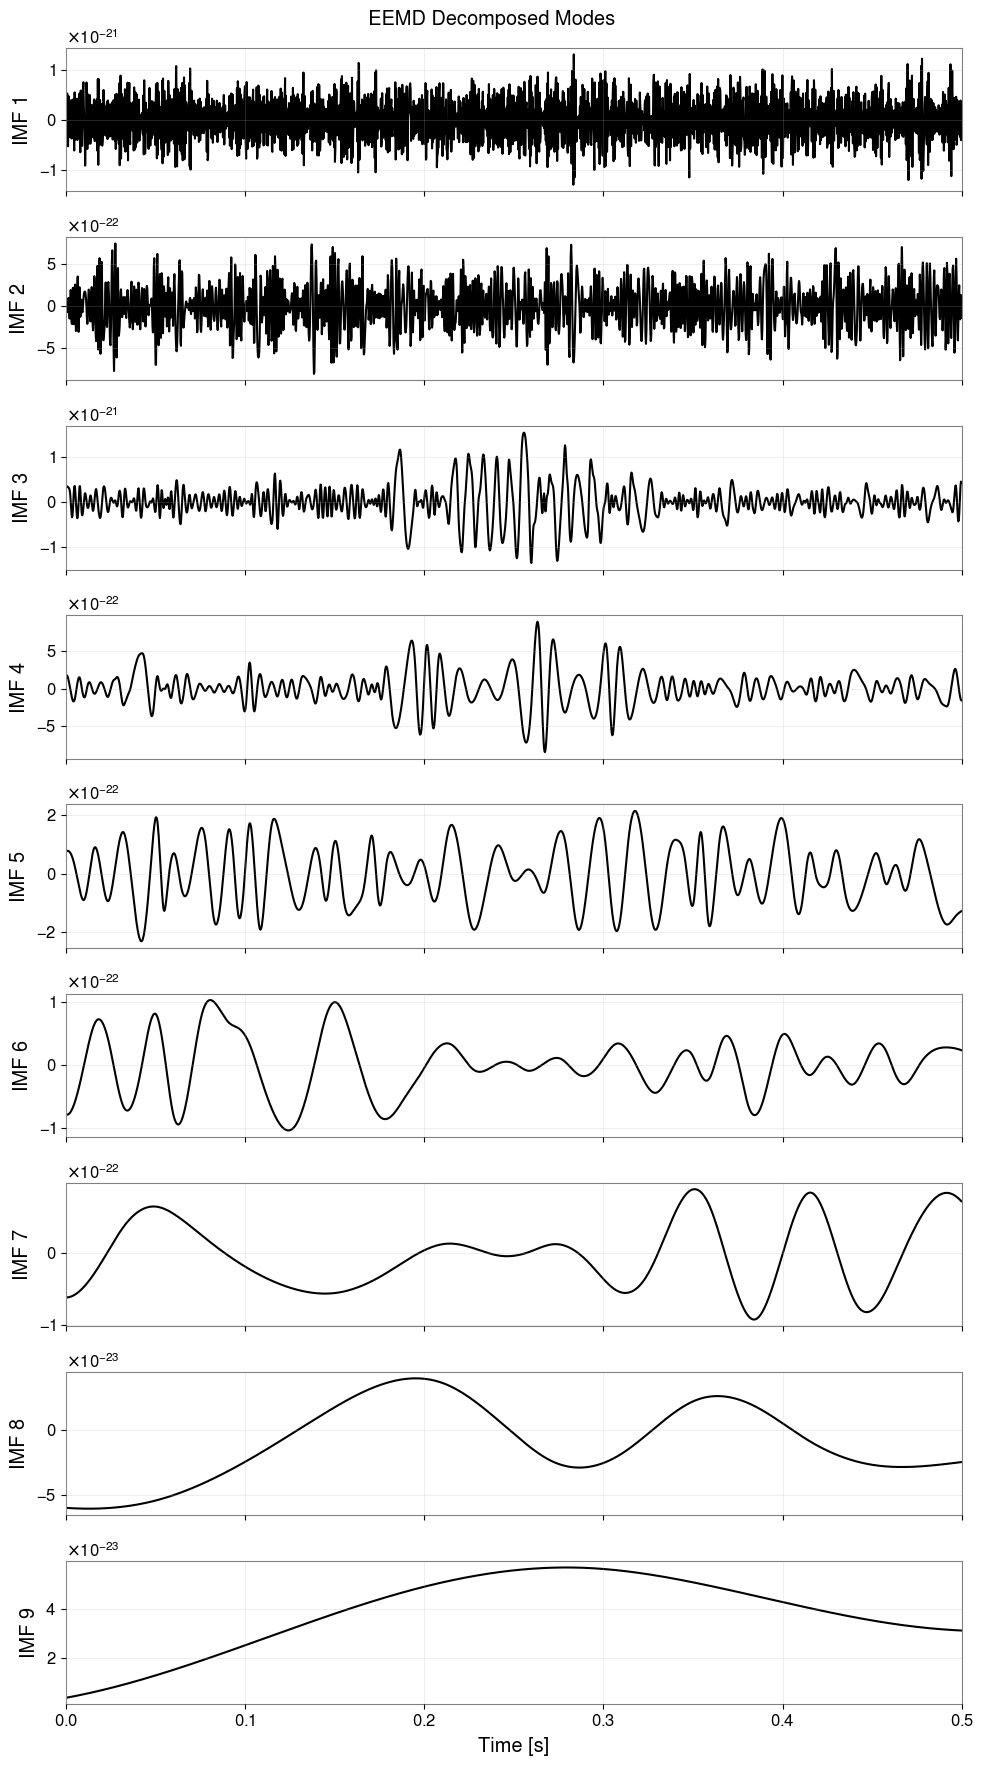

In [4]:
# Run EEMD (gwexpy API)

print("Running EEMD on normalized data via TimeSeries.hht()...")
eemd_result = ts_norm.hht(
    emd_method="eemd",
    emd_kwargs={
        "eemd_trials": 10,
        "eemd_noise_std": 0.2,
        "random_state": 42,
        "sift_max_iter": 200,
        "stopping_criterion": 0.2,
    },
    hilbert_kwargs={
        "pad": 200,
        "if_smooth": 11,
    },
    output="dict",
)

eimfs = eemd_result["imfs"]
n_eimfs = len(eimfs)
print(f"EEMD completed. Extracted {n_eimfs} IMFs.")

# Visualize all IMFs
fig, axes = plt.subplots(n_eimfs, 1, figsize=(10, 2 * n_eimfs), sharex=True)
if n_eimfs == 1:
    axes = [axes]

for i, key in enumerate(eimfs.keys()):
    imf_ts = eimfs[key]
    axes[i].plot(imf_ts.times.value, imf_ts.value * data_std, "k")
    axes[i].set_ylabel(f"IMF {i + 1}")
    axes[i].grid(alpha=0.3)
    if i == n_eimfs - 1:
        axes[i].set_xlabel("Time [s]")
        axes[i].set_xlim(0, duration)

plt.suptitle("EEMD Decomposed Modes")
plt.tight_layout()
plt.show()